In [13]:
library(gridExtra)
library(matrixStats)
library(dplyr)
library(rlang)
library(reshape2)
library(clusterCrit)
library(grid)
library(ggrepel)
library(RColorBrewer)
library(dplyr)
library(IRdisplay)
library(scales)
library(survival)
library(corrplot)
library(Hmisc)
library(ggplot2)
library(dummies)
source('../../../src/tools.R')     # custom tools function
source('../../../src/hdp_tools_yanis.R')
source("../../../src/merge_df.R")
source("../../../src/my_toolbox.R")
source("../../../src/my_components.R")
source("../../../src/my_utils.R")
source("../../../src/ggstyles.R")
source("../../../src/my_hotspots.R")
###


theme_set(theme_minimal())

# set jupyer notebook parameters
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 200, # set the maximum number of rows displayed
        repr.matrix.max.cols = 200) # set the maximum number of columns displayed

In [17]:
df_final <- read.table("df_final_with_comp.tsv")[,c(1:156)]

In [5]:
list_component <- unique(df_final[order(df_final$final_component_numeric),]$final_component)
list_component

[1] t_15_17               inv_16                t_8_21               
 [4] t_11                  t_6_9                 inv_3                
 [7] additions             TP53_complex          NPM1                 
[10] CEBPA_bi              DNMT3A_IDH1_2         WT1                  
[13] chr_splicing_multiple chr_splicing_1        not_assigned         
[16] no_events            
16 Levels: additions CEBPA_bi chr_splicing_1 ... WT1

In [54]:
tmp <- df_final
factors <- c("ZRSR2","U2AF1_p.S34","U2AF1_p.Q157","SRSF2","SF3B1","ASXL1","STAG2","BCOR","RUNX1","EZH2","MLL","PHF6","SF1","NF1","CUX1","SETBP1")
tmp$comp_t_15_17 <- ifelse((df_final$t_15_17==1),1,0) 
tmp$comp_inv_16 <- ifelse((df_final$inv_16==1),1,0) 
tmp$comp_t_8_21 <- ifelse((df_final$t_8_21==1),1,0) 
tmp$comp_t_11 <- ifelse((df_final$t_v_11==1 | df_final$t_9_11==1),1,0)   
tmp$comp_t_6_9 <- ifelse((df_final$t_6_9==1),1,0) 
tmp$comp_inv_3 <- ifelse((df_final$inv_3==1),1,0)
tmp$comp_additions <- ifelse((df_final$add_8==1 | df_final$add_13==1 | df_final$add_21==1 | df_final$add_22==1),1,0)
tmp$comp_TP53_complex <- ifelse((df_final$TP53==1 | df_final$complex==1) ,1,0)
tmp$comp_NPM1 <- ifelse((df_final$NPM1==1),1,0) 
tmp$comp_CEBPA_bi <- ifelse((df_final$CEBPA_bi==1),1,0) 
tmp$comp_DNMT3A_IDH1_2 <- ifelse((df_final$DNMT3A==1 & (df_final$IDH1==1 | df_final$IDH2_p.R140==1 | df_final$IDH2_p.R172==1)),1,0)
tmp$comp_WT1 <- ifelse((df_final$WT1==1),1,0) 
tmp$comp_chr_splicing_multiple <- ifelse((rowSums(df_final[,factors])>1) ,1,0)
tmp$comp_chr_splicing_1 <- ifelse((rowSums(df_final[,factors])==1),1,0)
tmp$comp_not_assigned <- ifelse(df_final$final_component=="not_assigned",1,0)
tmp$comp_no_events <- ifelse(df_final$final_component=="no_events",1,0)

tmp$num_comp_fit <- rowSums(tmp[,c(157:172)])
tmp$overlap <- ifelse(tmp$num_comp_fit>1,1,0)
    
#write.table(tmp,"df_final_with_multiple_comp.tsv")   

In [27]:
correlates <- c("ahd","perf_status","bm_blasts","secondary","wbc","hb","plt","gender","age","os","os_status")
df_final <- read.table("df_final_with_multiple_comp.tsv")
for (col in colnames(df_final[,startsWith(colnames(df_final),"comp_")])){
    df_final[,gsub("comp_","overlap_",col)] <- 0 
}
### Components t_15_17,inv_16,t_8_21,t_11,t_6_9,inv_3,NPM1,

for (col in c("t_15_17","inv_16","t_8_21","t_11","t_6_9","inv_3","NPM1","CEBPA_bi","TP53_complex")){
    for (col_bis in colnames(df_final[,startsWith(colnames(df_final),"comp_")])){
        if (!is.element(col_bis,c("comp_additions","comp_WT1","comp_chr_splicing_1","comp_DNMT3A_IDH1_2",paste("comp",col,sep="_")))){
            try(df_final[df_final$final_component==col  , gsub("comp_","overlap_",col_bis)] <- df_final[df_final$final_component==col,col_bis])
        }
    }      
}

### Component additions
df_final[df_final$final_component=="additions" & df_final$comp_TP53_complex==1 & (df_final$del_7==1 | df_final$del_17==1 | df_final$del_5==1 | df_final$del_9==1 |
         df_final$del_13==1 | df_final$del_20==1 | df_final$del_18==1 | df_final$del_16==1 | df_final$del_12==1 | df_final$del_3==1),"overlap_TP53_complex"] <- 1
df_final[df_final$final_component=="additions" & df_final$comp_chr_splicing_multiple==1,"overlap_chr_splicing_multiple"] <- 1
df_final[df_final$final_component=="additions" & df_final$comp_chr_splicing_1==1,"overlap_chr_splicing_1"] <- 1

### Component TP53 complex continuation
df_final[df_final$final_component=="TP53_complex" & df_final$comp_additions==1 & (df_final$del_7==1 | df_final$del_17==1 | df_final$del_5==1 | df_final$del_9==1 |
         df_final$del_13==1 | df_final$del_20==1 | df_final$del_18==1 | df_final$del_16==1 | df_final$del_12==1 | df_final$del_3==1),"overlap_additions"] <- 1

### Component DNMT3A_IDH1_2
df_final[df_final$final_component=="DNMT3A_IDH1_2" & df_final$comp_WT1==1,"overlap_WT1"] <- 1
df_final[df_final$final_component=="DNMT3A_IDH1_2" & df_final$comp_chr_splicing_multiple==1,"overlap_chr_splicing_multiple"] <- 1
df_final[df_final$final_component=="DNMT3A_IDH1_2" & df_final$comp_chr_splicing_1==1,"overlap_chr_splicing_1"] <- 1

### Component WT1
df_final[df_final$final_component=="WT1" & df_final$comp_DNMT3A_IDH1_2==1,"overlap_DNMT3A_IDH1_2"] <- 1
df_final[df_final$final_component=="WT1" & df_final$comp_chr_splicing_multiple==1,"overlap_chr_splicing_multiple"] <- 1
df_final[df_final$final_component=="WT1" & df_final$comp_chr_splicing_1==1,"overlap_chr_splicing_1"] <- 1

### Component chr splicing 1
df_final[df_final$final_component=="chr_splicing_1" & df_final$comp_additions==1,"overlap_additions"] <- 1
df_final[df_final$final_component=="chr_splicing_1" & df_final$comp_WT1==1,"overlap_WT1"] <- 1
df_final[df_final$final_component=="chr_splicing_1" & df_final$comp_DNMT3A_IDH1_2==1,"overlap_DNMT3A_IDH1_2"] <- 1

### Component chr splicing multiple
for (col in colnames(df_final[,startsWith(colnames(df_final),"comp_")])){
    if(col!="comp_chr_splicing_multiple"){
        df_final[df_final$final_component=="chr_splicing_multiple"  , gsub("comp_","overlap_",col)] <- df_final[df_final$final_component=="chr_splicing_multiple",col]
    }
}
#write.table(df_final,"df_final_multiple_comp_overlap_comp.tsv")

NULL

In [39]:
correlates <- c("ahd","perf_status","bm_blasts","secondary","wbc","hb","plt","gender","age","os","os_status")
continuous_correlates <- c("age","wbc","hb","plt","bm_blasts","os")
df_all_components <- read.table("../../clustering/Clustering_Final_1/df_final_multiple_comp_overlap_comp.tsv")[,c(1:156,175:190)]

df_initial <- read.table("../../../data/initial_dataset/Master_04_10_2019.csv",sep = ',' , header = T)
rownames(df_initial) <- df_initial$data_pd
df_initial <- df_initial[,-1:-4]
df_eln <- read.table("../../../data/updated_dataset/eln_final.tsv",sep = '\t' , header = T)
rownames(df_eln) <- df_eln$X
df_eln <- df_eln[-1]
df <- merge(df_eln,df_all_components,by=0)
rownames(df) <- df$Row.names
df <- df[-1]
df <- merge(df,df_initial[,correlates],by=0)
rownames(df) <- df$Row.names
df <- df[-1]
for (col in colnames(df)[colSums(is.na(df)) > 0]){
    if(!is.element(col,c("os","os_status"))){        
        if(is.element(col,continuous_correlates)){
            df[,col][is.na(df[,col])] <- mean(df[,col], na.rm=TRUE)
        }else{
            df[,col][is.na(df[,col])] <- median(df[,col], na.rm=TRUE)
            }
    }
   
}
df <- na.omit(df)
df <- df[df$os>0,]

df$eln_2017 <- ifelse(df$eln_2017=="adverse",1,
                    ifelse(df$eln_2017=="intermediate",2,3))
df<- cbind(df,dummy('final_component',df, sep = "_"))
overlap_comp <- colnames(df[,startsWith(colnames(df),"overlap_"),])
df$overlap <- 0
for (comp in colnames(df[,startsWith(colnames(df),"final_component_"),])){
    df[df[,comp]==1,]$overlap <- ifelse(rowSums(df[df[,comp]==1,overlap_comp])>0,1,0)
}
df <- df[,c(1:158,177:185,159,160,188:204,161:176,186:187)]
df$overlap_NPM1 <- NULL
df$overlap_not_assigned <- NULL
df$overlap_no_events <- NULL
for (col in (colnames(df[,startsWith(colnames(df),"final_component_"),]))){
    if(col!="final_component_numeric"){
        if (is.element(col,c('final_component_not_assigned','final_component_no_events','final_component_NPM1'))){
            df[,gsub('final','full',col)] <- df[,col]
        }
        else{
            df[,gsub('final','full',col)] <- df[,col] + df[,gsub('final_component','overlap',col)]
        }
    }    
}
df <- df[,c(1:199,202:217,200:201)]
write.table(df,"df_final_analysis.tsv")

In [148]:
# Final Table to use without ITD
continuous_correlates <- c("age","wbc","hb","plt","bm_blasts","os")


df_final <- read.table("df_final_with_comp.tsv")[,c(1:156)]
tmp <- df_final
factors <- c("ZRSR2","U2AF1_p.S34","U2AF1_p.Q157","SRSF2","SF3B1","ASXL1","STAG2","BCOR","RUNX1","EZH2","MLL","PHF6","SF1","NF1","CUX1","SETBP1")
correlates <- c("ahd","perf_status","bm_blasts","secondary","wbc","hb","plt","gender","age","os","os_status")
tmp$full_component_t_15_17 <- ifelse((df_final$t_15_17==1),1,0) 
tmp$full_component_inv_16 <- ifelse((df_final$inv_16==1),1,0) 
tmp$full_component_t_8_21 <- ifelse((df_final$t_8_21==1),1,0) 
tmp$full_component_t_11 <- ifelse((df_final$t_v_11==1 | df_final$t_9_11==1),1,0)   
tmp$full_component_t_6_9 <- ifelse((df_final$t_6_9==1),1,0) 
tmp$full_component_inv_3 <- ifelse((df_final$inv_3==1),1,0)
tmp$full_component_additions <- ifelse((df_final$add_8==1 | df_final$add_13==1 | df_final$add_21==1 | df_final$add_22==1),1,0)
tmp$full_component_TP53_complex <- ifelse((df_final$TP53==1 | df_final$complex==1) ,1,0)
tmp$full_component_NPM1 <- ifelse((df_final$NPM1==1),1,0) 
tmp$full_component_CEBPA_bi <- ifelse((df_final$CEBPA_bi==1),1,0) 
tmp$full_component_DNMT3A_IDH1_2 <- ifelse((df_final$DNMT3A==1 & (df_final$IDH1==1 | df_final$IDH2_p.R140==1 | df_final$IDH2_p.R172==1)),1,0)
tmp$full_component_WT1 <- ifelse((df_final$WT1==1),1,0) 
tmp$full_component_chr_splicing_multiple <- ifelse((rowSums(df_final[,factors])>1) ,1,0)
tmp$full_component_chr_splicing_1 <- ifelse((rowSums(df_final[,factors])==1),1,0)
tmp$full_component_not_assigned <- ifelse(df_final$final_component=="not_assigned",1,0)
tmp$full_component_no_events <- ifelse(df_final$final_component=="no_events",1,0)

df_initial <- read.table("../../../data/initial_dataset/Master_04_10_2019.csv",sep = ',' , header = T)
rownames(df_initial) <- df_initial$data_pd
df_initial <- df_initial[,-1:-4]
df_eln <- read.table("../../../data/updated_dataset/eln_final.tsv",sep = '\t' , header = T)
rownames(df_eln) <- df_eln$X
df_eln <- df_eln[-1]
df <- merge(df_eln,tmp,by=0)
rownames(df) <- df$Row.names
df <- df[-1]
df <- merge(df,df_initial[,correlates],by=0)
rownames(df) <- df$Row.names
df <- df[-1]
for (col in colnames(df)[colSums(is.na(df)) > 0]){
    if(!is.element(col,c("os","os_status"))){        
        if(is.element(col,continuous_correlates)){
            df[,col][is.na(df[,col])] <- mean(df[,col], na.rm=TRUE)
        }else{
            df[,col][is.na(df[,col])] <- median(df[,col], na.rm=TRUE)
            }
    }
   
}
df <- na.omit(df)
df <- df[df$os>0,]

# Handling additions
df[df$full_component_additions==1 & (df$full_component_t_15_17==1 | df$full_component_inv_16==1 | df$full_component_t_8_21==1 | df$full_component_t_11==1 | df$full_component_t_6_9==1 | df$full_component_inv_3==1 | df$full_component_NPM1==1 | df$full_component_CEBPA_bi==1 | df$full_component_DNMT3A_IDH1_2==1 | df$full_component_WT1==1 ),"full_component_additions"] <- 0
df[df$full_component_additions==1 & (df$full_component_TP53_complex==1) & (df$del_7==1 | df$del_17==1 | df$del_5==1 | df$del_9==1 |df$del_13==1 | df$del_20==1 | df$del_18==1 | df$del_16==1 | df$del_12==1 | df$del_3==1),"full_component_additions"] <- 1

# Handling DNMT3A IDH
df[df$full_component_DNMT3A_IDH1_2==1 & (df$full_component_t_15_17==1 | df$full_component_inv_16==1 | df$full_component_t_8_21==1 | df$full_component_t_11==1 | df$full_component_t_6_9==1 | df$full_component_inv_3==1 | df$full_component_TP53_complex==1 | df$full_component_NPM1==1 | df$full_component_CEBPA_bi==1 | df$full_component_additions==1 ),"full_component_DNMT3A_IDH1_2"] <- 0

# Handling WT1
df[df$full_component_WT1==1 & (df$full_component_t_15_17==1 | df$full_component_inv_16==1 | df$full_component_t_8_21==1 | df$full_component_t_11==1 | df$full_component_t_6_9==1 | df$full_component_inv_3==1 | df$full_component_TP53_complex==1 | df$full_component_NPM1==1 | df$full_component_CEBPA_bi==1 ),"full_component_WT1"] <- 0

# Handling chr_splicing_1
df[df$full_component_chr_splicing_1==1 & (df$full_component_t_15_17==1 | df$full_component_inv_16==1 | df$full_component_t_8_21==1 | df$full_component_t_11==1 | df$full_component_t_6_9==1 | df$full_component_inv_3==1 | df$full_component_TP53_complex==1 | df$full_component_NPM1==1 | df$full_component_CEBPA_bi==1 ),"full_component_chr_splicing_1"] <- 0

df$overlap <- 0
df[rowSums(df[,colnames(df[,startsWith(colnames(df),
                                       
                                       "full_component_"),])])>1,"overlap"] <- 1
df <- df[,c(1:158,177:185,159:176,188,186:187)]
df$eln_2017 <- ifelse(df$eln_2017=="adverse",1,
                    ifelse(df$eln_2017=="intermediate",2,3))
write.table(df,"df_final_full_component.tsv")

In [44]:
# With ITD

continuous_correlates <- c("age","wbc","hb","plt","bm_blasts","os")


df_final <- read.table("df_final_with_comp.tsv")[,c(1:156)]
tmp <- df_final
factors <- c("ZRSR2","U2AF1_p.S34","U2AF1_p.Q157","SRSF2","SF3B1","ASXL1","STAG2","BCOR","RUNX1","EZH2","MLL","PHF6","SF1","NF1","CUX1","SETBP1")
correlates <- c("ahd","perf_status","bm_blasts","secondary","wbc","hb","plt","gender","age","os","os_status")
tmp$full_component_t_15_17 <- ifelse((df_final$t_15_17==1),1,0)

tmp$full_component_inv_16 <- ifelse((df_final$inv_16==1),1,0) 

tmp$full_component_t_8_21 <- ifelse((df_final$t_8_21==1 & df_final$ITD==0),1,0)
tmp$full_component_t_8_21_ITD <- ifelse((df_final$t_8_21==1 & df_final$ITD==1),1,0) 

tmp$full_component_t_11 <- ifelse((df_final$t_v_11==1 | df_final$t_9_11==1),1,0)   

tmp$full_component_t_6_9 <- ifelse((df_final$t_6_9==1 & df_final$ITD==0),1,0)
tmp$full_component_t_6_9_ITD <- ifelse((df_final$t_6_9==1 & df_final$ITD==1),1,0)

tmp$full_component_inv_3 <- ifelse((df_final$inv_3==1),1,0)

tmp$full_component_additions <- ifelse((df_final$add_8==1 | df_final$add_13==1 | df_final$add_21==1 | df_final$add_22==1),1,0)

tmp$full_component_TP53_complex <- ifelse((df_final$TP53==1 | df_final$complex==1) ,1,0)

tmp$full_component_NPM1 <- ifelse((df_final$NPM1==1 & df_final$ITD==0),1,0) 
tmp$full_component_NPM1_ITD <- ifelse((df_final$NPM1==1 & df_final$ITD==1),1,0)

tmp$full_component_CEBPA_bi <- ifelse((df_final$CEBPA_bi==1 & df_final$ITD==0),1,0) 
tmp$full_component_CEBPA_bi_ITD <- ifelse((df_final$CEBPA_bi==1 & df_final$ITD==1),1,0)

tmp$full_component_DNMT3A_IDH1_2 <- ifelse((df_final$DNMT3A==1 & (df_final$IDH1==1 | df_final$IDH2_p.R140==1 | df_final$IDH2_p.R172==1) & df_final$ITD==0),1,0)
tmp$full_component_DNMT3A_IDH1_2_ITD <- ifelse((df_final$DNMT3A==1 & (df_final$IDH1==1 | df_final$IDH2_p.R140==1 | df_final$IDH2_p.R172==1) & df_final$ITD==1),1,0)

tmp$full_component_WT1 <- ifelse((df_final$WT1==1 & df_final$ITD==0),1,0) 
tmp$full_component_WT1_ITD <- ifelse((df_final$WT1==1 & df_final$ITD==1),1,0)

tmp$full_component_chr_splicing_multiple <- ifelse((rowSums(df_final[,factors])>1) ,1,0)

tmp$full_component_chr_splicing_1 <- ifelse((rowSums(df_final[,factors])==1),1,0)

tmp$full_component_not_assigned <- ifelse(df_final$final_component=="not_assigned" & df_final$ITD==0,1,0)
tmp$full_component_not_assigned_ITD <- ifelse(df_final$final_component=="not_assigned" & df_final$ITD==1,1,0)

tmp$full_component_no_events <- ifelse(df_final$final_component=="no_events",1,0)


df_initial <- read.table("../../../data/initial_dataset/Master_04_10_2019.csv",sep = ',' , header = T)
rownames(df_initial) <- df_initial$data_pd
df_initial <- df_initial[,-1:-4]
df_eln <- read.table("../../../data/updated_dataset/eln_final.tsv",sep = '\t' , header = T)
rownames(df_eln) <- df_eln$X
df_eln <- df_eln[-1]
df <- merge(df_eln,tmp,by=0)
rownames(df) <- df$Row.names
df <- df[-1]
df <- merge(df,df_initial[,correlates],by=0)
rownames(df) <- df$Row.names
df <- df[-1]
for (col in colnames(df)[colSums(is.na(df)) > 0]){
    if(!is.element(col,c("os","os_status"))){        
        if(is.element(col,continuous_correlates)){
            df[,col][is.na(df[,col])] <- mean(df[,col], na.rm=TRUE)
        }else{
            df[,col][is.na(df[,col])] <- median(df[,col], na.rm=TRUE)
            }
    }
   
}
df <- na.omit(df)
df <- df[df$os>0,]

# Handling additions
df[df$full_component_additions==1 & (df$full_component_t_15_17==1 | df$full_component_inv_16==1 | df$full_component_t_8_21==1 |df$full_component_t_8_21_ITD==1 |
                                     df$full_component_t_11==1 | df$full_component_t_6_9==1 | df$full_component_t_6_9_ITD==1 | df$full_component_inv_3==1 |
                                     df$full_component_NPM1==1 |df$full_component_NPM1_ITD==1 | df$full_component_CEBPA_bi==1 | df$full_component_CEBPA_bi_ITD==1 |
                                     df$full_component_DNMT3A_IDH1_2==1 | df$full_component_DNMT3A_IDH1_2_ITD==1 | df$full_component_WT1==1 | df$full_component_WT1_ITD==1),"full_component_additions"] <- 0

df[df$full_component_additions==1 & (df$full_component_TP53_complex==1) & (df$del_7==1 | df$del_17==1 | df$del_5==1 | df$del_9==1 |df$del_13==1 |
                                                                           df$del_20==1 | df$del_18==1 | df$del_16==1 | df$del_12==1 | df$del_3==1),"full_component_additions"] <- 1

# Handling DNMT3A IDH
df[df$full_component_DNMT3A_IDH1_2==1 & (df$full_component_t_15_17==1 | df$full_component_inv_16==1 | df$full_component_t_8_21==1 | df$full_component_t_8_21_ITD==1 | df$full_component_t_11==1 |
                                         df$full_component_t_6_9==1 | df$full_component_t_6_9_ITD==1 | df$full_component_inv_3==1 | df$full_component_TP53_complex==1 | df$full_component_NPM1==1 |
                                         df$full_component_NPM1_ITD==1 | df$full_component_CEBPA_bi==1 | df$full_component_CEBPA_bi_ITD==1 | df$full_component_additions==1 ),"full_component_DNMT3A_IDH1_2"] <- 0

df[df$full_component_DNMT3A_IDH1_2_ITD==1 & (df$full_component_t_15_17==1 | df$full_component_inv_16==1 | df$full_component_t_8_21==1 | df$full_component_t_8_21_ITD==1 | df$full_component_t_11==1 |
                                         df$full_component_t_6_9==1 | df$full_component_t_6_9_ITD==1 | df$full_component_inv_3==1 | df$full_component_TP53_complex==1 | df$full_component_NPM1==1 |
                                         df$full_component_NPM1_ITD==1 | df$full_component_CEBPA_bi==1 | df$full_component_CEBPA_bi_ITD==1 | df$full_component_additions==1 ),"full_component_DNMT3A_IDH1_2_ITD"] <- 0

# Handling WT1
df[df$full_component_WT1==1 & (df$full_component_t_15_17==1 | df$full_component_inv_16==1 | df$full_component_t_8_21==1 | df$full_component_t_8_21_ITD==1 | df$full_component_t_11==1 |
                               df$full_component_t_6_9==1 | df$full_component_t_6_9_ITD==1 | df$full_component_inv_3==1 | df$full_component_TP53_complex==1 | df$full_component_NPM1==1 |
                               df$full_component_NPM1_ITD==1 | df$full_component_CEBPA_bi==1 | df$full_component_CEBPA_bi_ITD==1 ),"full_component_WT1"] <- 0

df[df$full_component_WT1_ITD==1 & (df$full_component_t_15_17==1 | df$full_component_inv_16==1 | df$full_component_t_8_21==1 | df$full_component_t_8_21_ITD==1 | df$full_component_t_11==1 |
                               df$full_component_t_6_9==1 | df$full_component_t_6_9_ITD==1 | df$full_component_inv_3==1 | df$full_component_TP53_complex==1 | df$full_component_NPM1==1 |
                               df$full_component_NPM1_ITD==1 | df$full_component_CEBPA_bi==1 | df$full_component_CEBPA_bi_ITD==1 ),"full_component_WT1_ITD"] <- 0


# Handling chr_splicing_1
df[df$full_component_chr_splicing_1==1 & (df$full_component_t_15_17==1 | df$full_component_inv_16==1 | df$full_component_t_8_21==1 | df$full_component_t_8_21_ITD==1 |
                                          df$full_component_t_11==1 | df$full_component_t_6_9==1 | df$full_component_t_6_9_ITD==1 | df$full_component_inv_3==1 |
                                          df$full_component_TP53_complex==1 | df$full_component_NPM1==1 | df$full_component_NPM1_ITD==1 | df$full_component_CEBPA_bi==1 | df$full_component_CEBPA_bi_ITD==1 ),"full_component_chr_splicing_1"] <- 0

df$overlap <- 0
df[rowSums(df[,colnames(df[,startsWith(colnames(df),"full_component_"),])])>1,"overlap"] <- 1
df <- df[,c(1:158,184:192,159:183,195,193:194)]
df$eln_2017 <- ifelse(df$eln_2017=="adverse",1,
                    ifelse(df$eln_2017=="intermediate",2,3))
write.table(df,"df_final_full_component_ITD.tsv")

Final Component (HDP),additions,CEBPA_bi,chr_splicing_1,chr_splicing_multiple,DNMT3A_IDH1_2,inv_16,inv_3,no_events,not_assigned,NPM1,t_11,t_15_17,t_6_9,t_8_21,TP53_complex,WT1
Num of Patients,56,38,179,397,63,87,14,51,121,678,61,20,13,99,199,49


Overlap,0,1
Num of Patients,1755,370


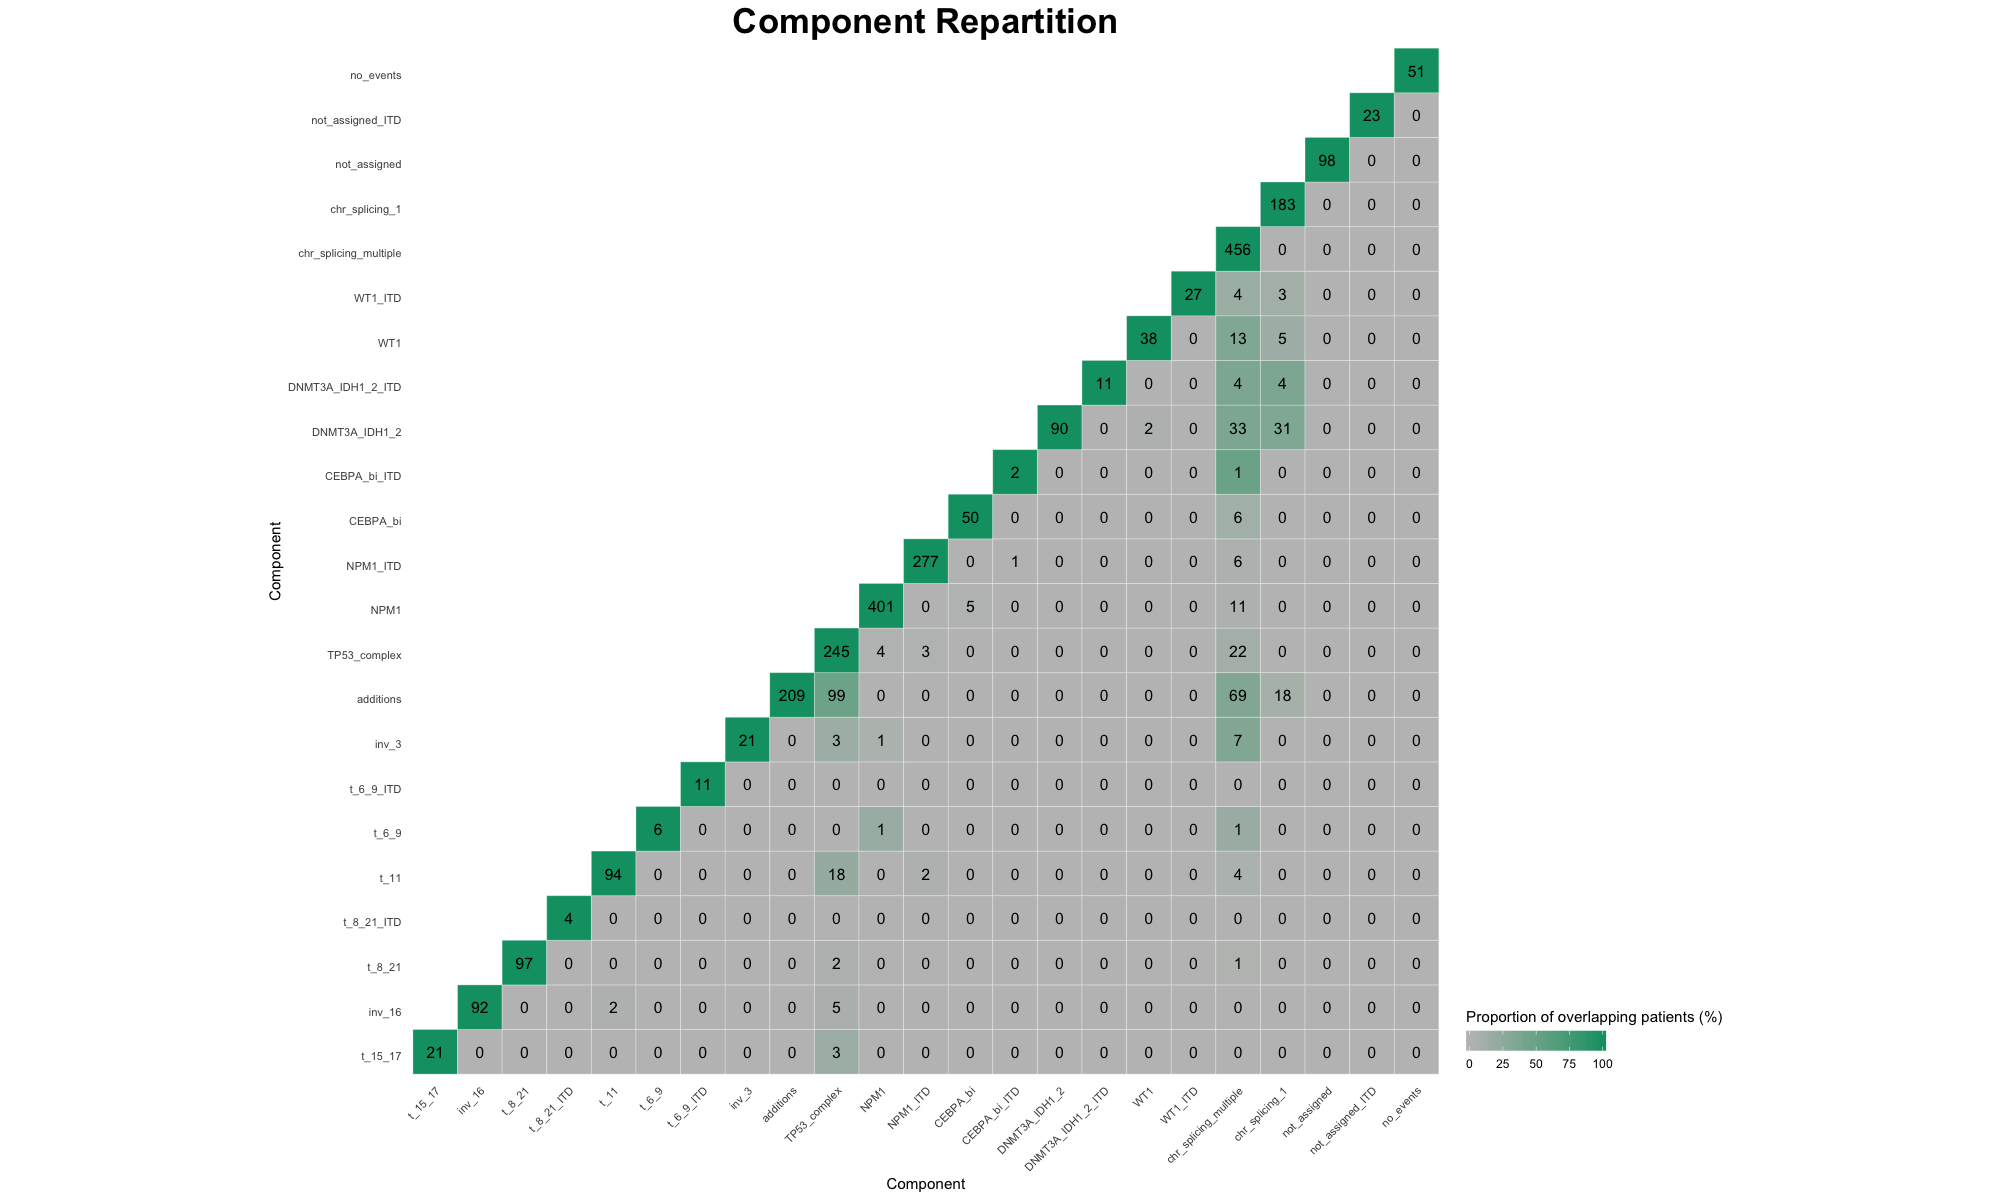

In [45]:
df_w_correlates <- read.table("df_final_full_component_ITD.tsv")
df_final <- read.table("df_final_full_component_ITD.tsv")
col_list <- c("t_15_17","inv_16","t_8_21","t_8_21_ITD","t_11","t_6_9","t_6_9_ITD","inv_3","additions","TP53_complex","NPM1","NPM1_ITD","CEBPA_bi","CEBPA_bi_ITD","DNMT3A_IDH1_2","DNMT3A_IDH1_2_ITD","WT1","WT1_ITD","chr_splicing_multiple","chr_splicing_1","not_assigned","not_assigned_ITD","no_events")
cols_component <- colnames(df_final %>% dplyr:: select(starts_with("full_component_")))
df_tmp <- setNames(data.frame(matrix(ncol = length(col_list), nrow = length(col_list))), gsub("full_component_","",col_list))
rownames(df_tmp) <- gsub("full_component_","",col_list)
for (col in cols_component){
    for (col_bis in cols_component){
        df_tmp[gsub("full_component_","",col),gsub("full_component_","",col_bis)] <- ifelse(is.null(dim(df_final[df_final[,col]==1 & df_final[,col_bis]==1,])[1]),0,dim(df_final[df_final[,col]==1 & df_final[,col_bis]==1,])[1])
        }}

set_notebook_plot_size(20,12)
get_lower_tri<-function(cormat){
cormat[upper.tri(cormat)] <- NA
return(cormat)
}
# Get upper triangle of the correlation matrix
get_upper_tri <- function(cormat){
cormat[lower.tri(cormat)]<- NA
return(cormat)
}
upper_tri <- get_upper_tri(as.matrix(df_tmp))
melted_cormat <- melt(upper_tri, na.rm = TRUE)
melted_cormat <- cbind(melted_cormat, value_bis=0)
for (col in unique(melted_cormat$Var1)){
    melted_cormat[melted_cormat$Var1==col,]$value_bis <- 100*melted_cormat[melted_cormat$Var1==col,]$value / melted_cormat[melted_cormat$Var1==col & melted_cormat$Var2==col,]$value
    }
tmp <- t(data.frame(table(df_final$final_component)))
rownames(tmp) <- c("Final Component (HDP)","Num of Patients")
tmp
tmp <- t(data.frame(table(df_w_correlates$overlap)))
rownames(tmp) <- c("Overlap","Num of Patients")
tmp
ggplot(melted_cormat, aes(Var2, Var1, fill = value_bis))+
geom_tile(color = "white")+
scale_fill_gradient2(low = "#0072B2", high = "#009E73", mid = "#BFBFBF", 
  space = "Lab", 
name="Proportion of overlapping patients (%)") +
theme_minimal()+ # minimal theme
theme(axis.text.x = element_text(angle = 45, vjust = 1, 
size = 8, hjust = 1),axis.text.y = element_text( vjust = 1, 
size = 8, hjust = 1))+
coord_fixed()+
xlab("Component")+ylab("Component")+
geom_text(aes(Var2, Var1, label = value), color = "black", size = 4) +
theme(
panel.grid.major = element_blank(),
panel.border = element_blank(),
panel.background = element_blank(),
axis.ticks = element_blank(),
legend.justification = c(2, 0),
#legend.position = c(0.6, 0.7),
legend.direction = "horizontal",
plot.title=element_text(size=25,face="bold",hjust=0.5))+
guides(fill = guide_colorbar(barwidth = 7, barheight = 1,
            title.position = "top", title.hjust = 0.5))+
ggtitle("Component Repartition")